# Demonstration of anomaly detection with CVAE using DASHlink data

**Author: Milad Memarzadeh (milad.memarzadeh@nasa.gov)**


# Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import torch.nn.functional as F

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


# Load and preprocess data

In [2]:
# Define the path to the dataset
data_dir = 'C:/Users/jed95/Documents/GitHub/anomaly_detection/dataset/yahoo_s5/A1Benchmark'  # Adjust the path as necessary

# Get the list of all CSV files in the directory
file_list = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.csv')]

# Load all files into a single DataFrame
df_list = []
for file in file_list:
    df = pd.read_csv(file)
    df_list.append(df)

data = pd.concat(df_list, ignore_index=True)
print("Data shape:", data.shape)


Data shape: (94866, 3)


In [3]:
# Check for missing values
print("Missing values:", data.isnull().sum())

# For simplicity, drop missing values (if any)
data.dropna(inplace=True)


Missing values: timestamp     0
value         0
is_anomaly    0
dtype: int64


In [4]:
scaler = MinMaxScaler()
data['value'] = scaler.fit_transform(data['value'].values.reshape(-1, 1))


# Create Sequences

In [5]:
def create_sequences(values, labels, sequence_length):
    sequences = []
    seq_labels = []
    for i in range(len(values) - sequence_length + 1):
        seq = values[i:i + sequence_length]
        label = labels[i + sequence_length - 1]  # Label of the last element in the sequence
        sequences.append(seq)
        seq_labels.append(label)
    return np.array(sequences), np.array(seq_labels)
sequence_length = 30  # You can adjust this 
values = data['value'].values
labels = data['is_anomaly'].values  # Assuming 'is_anomaly' is the label column

sequences, seq_labels = create_sequences(values, labels, sequence_length)
print("Sequences shape:", sequences.shape)
print("Sequence labels shape:", seq_labels.shape)



Sequences shape: (94837, 30)
Sequence labels shape: (94837,)


# Split data into labeled and unlabeled sets

In [6]:
anomalous_indices = np.where(seq_labels == 1)[0]
normal_indices = np.where(seq_labels == 0)[0]


In [7]:
labeled_data = sequences[anomalous_indices]
labeled_labels = seq_labels[anomalous_indices]


In [8]:
from sklearn.utils import shuffle

# Shuffle normal indices
normal_indices = shuffle(normal_indices, random_state=42)

# Take a subset (e.g., 50%)
unlabeled_size = int(0.5 * len(normal_indices))
unlabeled_indices = normal_indices[:unlabeled_size]

unlabeled_data = sequences[unlabeled_indices]
unlabeled_labels = seq_labels[unlabeled_indices]  # Should be all zeros

# Optional: Combine the rest of the normal data into the unlabeled set
unlabeled_data = np.concatenate((unlabeled_data, sequences[normal_indices[unlabeled_size:]]), axis=0)
unlabeled_labels = np.concatenate((unlabeled_labels, seq_labels[normal_indices[unlabeled_size:]]), axis=0)


# Convert Data to Tensors

In [9]:
# Convert sequences to tensors
labeled_data_tensor = torch.tensor(labeled_data).float()
labeled_labels_tensor = torch.tensor(labeled_labels).long()  # Labels should be long integers

unlabeled_data_tensor = torch.tensor(unlabeled_data).float()
unlabeled_labels_tensor = torch.tensor(unlabeled_labels).long()


In [10]:
X_train_unlabeled, X_test_unlabeled, y_train_unlabeled, y_test_unlabeled = train_test_split(
    unlabeled_data_tensor, unlabeled_labels_tensor, test_size=0.2, random_state=42, stratify=unlabeled_labels_tensor)
X_train_anomalous, X_test_anomalous, y_train_anomalous, y_test_anomalous = train_test_split(
    labeled_data_tensor, labeled_labels_tensor, test_size=0.5, random_state=42, stratify=labeled_labels_tensor)
# For labeled data, since it's small, we can use all of it for training
X_train_labeled = labeled_data_tensor
y_train_labeled = labeled_labels_tensor
X_test = torch.cat([X_test_unlabeled, X_test_anomalous], dim=0)
y_test = torch.cat([y_test_unlabeled, y_test_anomalous], dim=0)


# Create Data Loaders for Labeled and Unlabeled Data

In [11]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = data
        self.labels = labels  # Can be None for unlabeled data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X = self.data[idx]
        if self.labels is not None:
            y = self.labels[idx]
            return X, y
        else:
            return X


In [12]:
batch_size = 64  # Adjust as needed

# Labeled training data loader
train_labeled_dataset = TimeSeriesDataset(X_train_labeled, y_train_labeled)
train_labeled_loader = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True)

# Unlabeled training data loader
train_unlabeled_dataset = TimeSeriesDataset(X_train_unlabeled)
train_unlabeled_loader = DataLoader(train_unlabeled_dataset, batch_size=batch_size, shuffle=True)

# Test data loader
test_dataset = TimeSeriesDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Instantiate and Train the Conditional VAE

In [13]:
# Parameters
latent_dim = 10  # Adjust as needed
num_param = 1    # Since we have univariate time series
window_size = sequence_length
num_classes = 2  # Normal and Anomaly
scale_flag = 0   # Use Sigmoid activation in the decoder
from source.modelsCondVAE import *
from source.utilsCondVAEs5 import *
# Instantiate the model
model = VAE(latent_dim, num_param, window_size, num_classes, scale_flag).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10  # Adjust as needed
train_model(model, optimizer, train_labeled_loader, train_unlabeled_loader, num_epochs)


Epoch [1/10], Total Loss: 197.9750, Rec Loss: 184.4424, KL Div: 4.2097, Class Loss: 9.3229
Epoch [2/10], Total Loss: 26.0940, Rec Loss: 25.4366, KL Div: 0.3889, Class Loss: 0.2685
Epoch [3/10], Total Loss: 55.5697, Rec Loss: 55.1491, KL Div: 0.2868, Class Loss: 0.1337
Epoch [4/10], Total Loss: 20.2051, Rec Loss: 19.0831, KL Div: 0.7760, Class Loss: 0.3461
Epoch [5/10], Total Loss: 311.3811, Rec Loss: 310.8451, KL Div: 0.2238, Class Loss: 0.3122
Epoch [6/10], Total Loss: 310.9208, Rec Loss: 310.8412, KL Div: 0.0796, Class Loss: 0.0000
Epoch [7/10], Total Loss: 310.8901, Rec Loss: 310.8433, KL Div: 0.0467, Class Loss: 0.0001
Epoch [8/10], Total Loss: 310.8967, Rec Loss: 310.8391, KL Div: 0.0574, Class Loss: 0.0003
Epoch [9/10], Total Loss: 310.8754, Rec Loss: 310.8470, KL Div: 0.0268, Class Loss: 0.0016
Epoch [10/10], Total Loss: 310.8752, Rec Loss: 310.8441, KL Div: 0.0290, Class Loss: 0.0021


# Evaluate the Model and Detect Anomalies

In [14]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score


def find_anomaly_scores(model, data_loader):
    model.eval()
    anomaly_scores = []
    true_labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.unsqueeze(1).to(device)
            y_batch = y_batch.to(device)

            x_rec, class_logits = model(X_batch)
            y_probs = F.softmax(class_logits, dim=1)

            # Reconstruction error
            rec_error = torch.mean((X_batch - x_rec) ** 2, dim=[1, 2])

            # Classification probability for anomaly class (assuming class 1 is anomaly)
            anomaly_prob = y_probs[:, 1]

            # Combine scores
            anomaly_score = rec_error * anomaly_prob

            anomaly_scores.extend(anomaly_score.cpu().numpy())
            true_labels.extend(y_batch.cpu().numpy())

    return np.array(anomaly_scores), np.array(true_labels)
# Compute anomaly scores
anomaly_scores, true_labels = find_anomaly_scores(model, test_loader)

# Verify unique labels
unique_labels = np.unique(true_labels)
print("Unique labels in true_labels:", unique_labels)

# Compute AUC-ROC
auc_score = roc_auc_score(true_labels, anomaly_scores)
print(f"AUC-ROC Score: {auc_score:.4f}")

# Compute Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(true_labels, anomaly_scores)
ap_score = average_precision_score(true_labels, anomaly_scores)
print(f"Average Precision Score: {ap_score:.4f}")


Unique labels in true_labels: [0 1]
AUC-ROC Score: 0.5497
Average Precision Score: 0.0445


In [15]:
print(anomaly_scores)
#print(true_labels)

[3.1008452e-04 8.3912648e-11 1.4282768e-14 ... 2.0783249e-07 2.8938305e-06
 1.9084490e-09]


In [16]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score

# Compute AUC-ROC
auc_score = roc_auc_score(true_labels, anomaly_scores)
print(f"AUC-ROC Score: {auc_score:.4f}")

# Compute Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(true_labels, anomaly_scores)
ap_score = average_precision_score(true_labels, anomaly_scores)
print(f"Average Precision Score: {ap_score:.4f}")


AUC-ROC Score: 0.5497
Average Precision Score: 0.0445


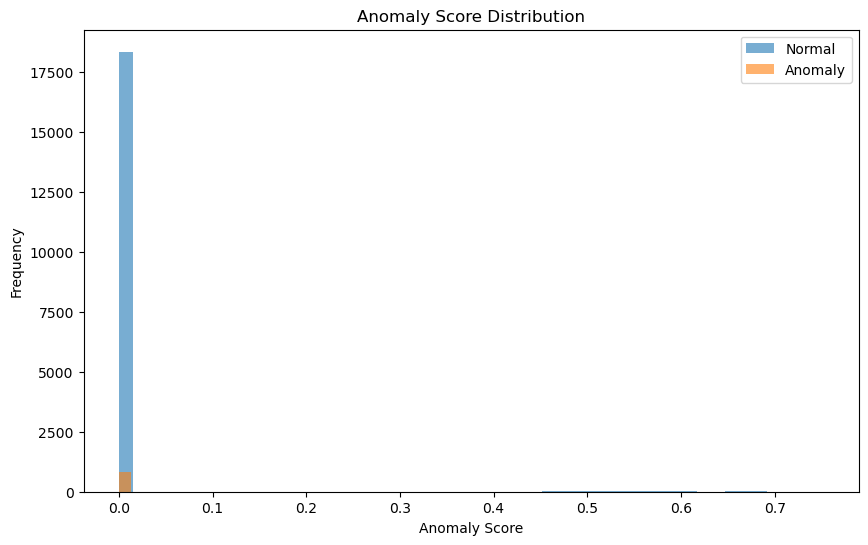

In [17]:
plt.figure(figsize=(10, 6))
plt.hist(anomaly_scores[true_labels == 0], bins=50, alpha=0.6, label='Normal')
plt.hist(anomaly_scores[true_labels == 1], bins=50, alpha=0.6, label='Anomaly')
plt.title('Anomaly Score Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()


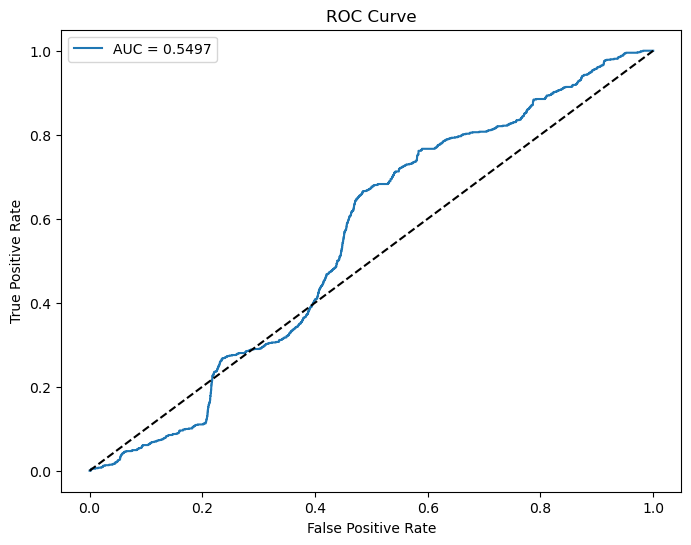

In [18]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(true_labels, anomaly_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
